# Neural Networks - Real Estate Data Set

> Joseph P. Vantassel, Texas Advanced Computing Center - The University of Texas at Austin

## Install Required Python Packages

For this example you will need several Python packages, you can use the cell below to install them. Be sure to restart your Jupyter kernel once the installation is complete, by going to `Kernel > Restart Kernel and Clear All Outputs ...`. Once your kernel restarts you can continue with the cell below the `Import Required Python Packages` header below.

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


## Import Required Python Packages

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

## Load Data Set

In [3]:
df = pd.read_csv("real_estate.csv")
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


## Preparing the Data

### Understanding the Data

We have 6 features:

- Transaction data (decimal years): last date the house sold
- House age (decimal years): years since built
- Distance to nearest MRT station (decimal meters): distance to nearest train station
- Number of Convenience stores (integer)
- Latitude (decimal degrees)
- Longitude (decimal degrees)
    
We have one value we are trying to predict:

- Unit price (decimal currency)

In [4]:
# convert to numpy
xfeatures = df.iloc[:, 1:-1].to_numpy()
xfeatures_labels = list(df.columns)[1:-1]
ypredict = df.iloc[:, -1].to_numpy()

# make sure we did the slices correctly
print(f"Row 0 (features): {xfeatures[0, :]}")
print(f"Row 0 (label): {ypredict[0]}")

Row 0 (features): [2012.917     32.        84.87882   10.        24.98298  121.54024]
Row 0 (label): 37.9


In [5]:
print(f"xfeatures.shape = {xfeatures.shape}")
print(f"ypredict.shape = {ypredict.shape}")

xfeatures.shape = (414, 6)
ypredict.shape = (414,)


In [6]:
np.min(ypredict), np.max(ypredict)

(7.6, 117.5)

### Shuffle & Split

Shuffle the dataset and split into train (70%), validation (15%), and test (15%) sets.

In [7]:
ptrain, pvalid, ptest = 0.7, 0.15, 0.15

# shuffle
rng = np.random.default_rng(1824)
shuffle_idxs = np.arange(len(ypredict))
rng.shuffle(shuffle_idxs)
xfeatures_shuffled = xfeatures[shuffle_idxs]
ypredict_shuffled = ypredict[shuffle_idxs]

# split
start_idx, stop_idx = 0, int(ptrain*len(ypredict))
xfeatures_train, ypredict_train = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_train.shape, ypredict_train.shape)


start_idx, stop_idx = stop_idx, stop_idx+int(pvalid*len(ypredict))
xfeatures_valid, ypredict_valid = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_valid.shape, ypredict_valid.shape)


start_idx, stop_idx = stop_idx, -1
xfeatures_test, ypredict_test = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_test.shape, ypredict_test.shape)

(289, 6) (289,)
(62, 6) (62,)
(62, 6) (62,)


### View the Training Set

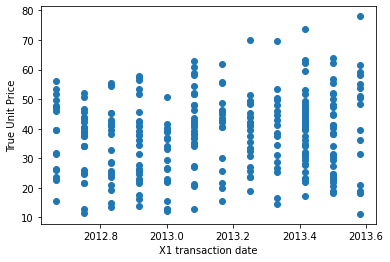

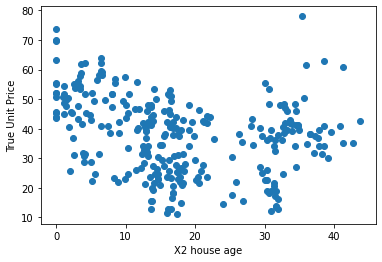

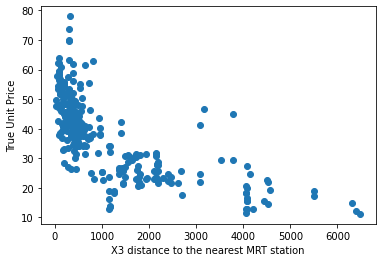

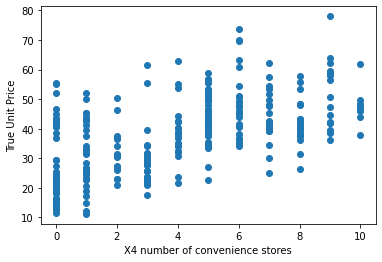

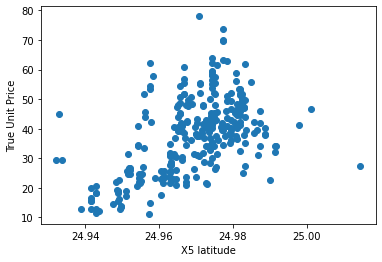

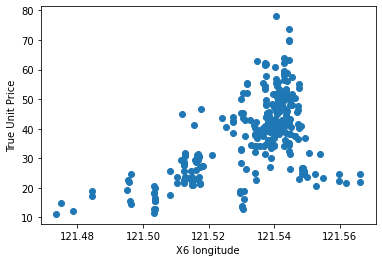

In [8]:
for feature, label in zip(xfeatures_train.T, xfeatures_labels):
    plt.scatter(feature, ypredict_train)
    plt.xlabel(label)
    plt.ylabel("True Unit Price")
    plt.show()

### Normalize Training Set

Scale the training set's features to consist of a series of small values (between approx -3 and 3) with a mean of zero.

In [9]:
xmeans = np.mean(xfeatures_train, axis=0)
print("xmeans", xmeans)
xstds = np.std(xfeatures_train, axis=0, ddof=1)
print("xstds", xstds)

xfeatures_train_normed = (xfeatures_train - xmeans) / xstds
xfeatures_valid_normed = (xfeatures_valid - xmeans) / xstds
xfeatures_test_normed = (xfeatures_test - xmeans) / xstds
print("min", np.min(xfeatures_train_normed, axis=0))
print("max", np.max(xfeatures_train_normed, axis=0))
print("mean", np.mean(xfeatures_train_normed, axis=0))
print("std", np.std(xfeatures_train_normed, axis=0))

xmeans [2013.15370934   17.73875433 1096.77751277    4.11418685   24.96912228
  121.53322848]
xstds [2.81894838e-01 1.14429633e+01 1.29862762e+03 2.96930584e+00
 1.26616573e-02 1.56482131e-02]
min [-1.72656351 -1.55018887 -0.82656079 -1.38557194 -2.92633759 -3.81503479]
max [1.5228752  2.27749097 4.15149302 1.98221856 3.59097669 2.11152048]
mean [-4.42653642e-12 -5.16407371e-16 -2.46630859e-16  4.45625851e-17
 -8.83526239e-14 -5.92967313e-12]
std [0.9982684 0.9982684 0.9982684 0.9982684 0.9982684 0.9982684]


## Create and Train a (Shallow) Neural Network

While we could write our own neural network, we will borrow keras' instead.

In [10]:
def get_model():
    inputs = keras.Input(shape=(len(xfeatures[0])))
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(1, activation="relu")(x)
    return keras.Model(inputs, x)
model = get_model()

In [11]:
loss = tf.keras.losses.MeanSquaredError(reduction="auto")

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9)

In [13]:
model.compile(optimizer=optimizer, loss=loss)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,633
Trainable params: 133,633
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Hyperparameters
batch_size = 32
epochs = 30
validation_split = 0.2

history = model.fit(xfeatures_train_normed, ypredict_train, validation_data=(xfeatures_valid_normed, ypredict_valid), epochs=epochs)

Epoch 1/30
10/10 [==============================] - 1s 20ms/step - loss: 1594.9497 - val_loss: 1564.2175
Epoch 2/30
10/10 [==============================] - 0s 5ms/step - loss: 1556.2620 - val_loss: 1488.8562
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 1441.1873 - val_loss: 1296.3015
Epoch 4/30
10/10 [==============================] - 0s 5ms/step - loss: 1099.7560 - val_loss: 589.5533
Epoch 5/30
10/10 [==============================] - 0s 5ms/step - loss: 256.7264 - val_loss: 254.0967
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 144.5749 - val_loss: 154.0530
Epoch 7/30
10/10 [==============================] - 0s 6ms/step - loss: 83.7779 - val_loss: 79.8076
Epoch 8/30
10/10 [==============================] - 0s 6ms/step - loss: 71.8609 - val_loss: 89.9598
Epoch 9/30
10/10 [==============================] - 0s 5ms/step - loss: 52.5270 - val_loss: 84.5396
Epoch 10/30
10/10 [==============================] - 0s 7ms/step - loss: 70.4157

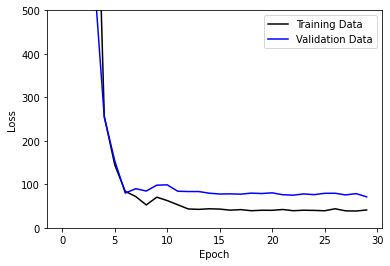

In [16]:
plt.plot(history.epoch, history.history["loss"], color="black", label="Training Data")
plt.plot(history.epoch, history.history["val_loss"], color="blue", label="Validation Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 500)
plt.legend()
plt.show()

10/10 [==============================] - 0s 2ms/step


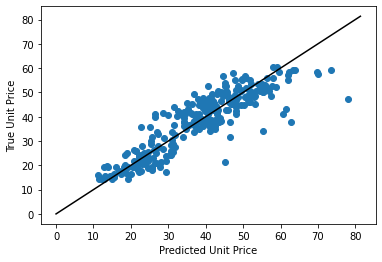

RMSE = 6.22


In [17]:
yhat_train = model.predict(xfeatures_train_normed).flatten()

plt.scatter(ypredict_train, yhat_train, marker="o")
value = np.max(plt.xlim())
plt.plot([0, value], [0, value], linestyle="-", color="black")
plt.xlabel("Predicted Unit Price")
plt.ylabel("True Unit Price")
plt.show()

print(f"RMSE = {np.sqrt(tf.keras.losses.MeanSquaredError()(yhat_train, ypredict_train)):.2f}")

### Predict on Validation Set

In [18]:
yhat_valid = model.predict(xfeatures_valid_normed).flatten()

2/2 [==============================] - 0s 5ms/step


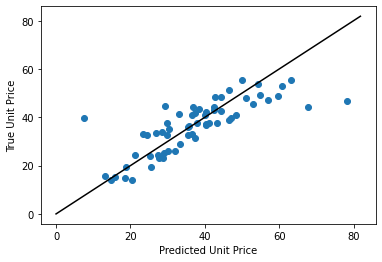

RMSE = 8.44


In [19]:
plt.scatter(ypredict_valid, yhat_valid, marker="o")
value = np.max(plt.xlim())
plt.plot([0, value], [0, value], linestyle="-", color="black")
plt.xlabel("Predicted Unit Price")
plt.ylabel("True Unit Price")
plt.show()

print(f"RMSE = {np.sqrt(tf.keras.losses.MeanSquaredError()(yhat_valid, ypredict_valid)):.2f}")

### Error Analysis

We were able to attain a training error (6.2) that is comparable to the best result from linear regression (6.0).
More importantly, we are getting validation error (8.4) that is similar/lower than what we were able to recover with linear
regression (9.4, 9.0, 8.8).